<h1><center>USD-JPY Price Prediction</center></h1>

This is a project by Erik Staszewski. The goal of this project is to predict the future value of the USD-JPY conversion rate. This project uses a dataset of US Dollar to Japanese Yen conversion rates from a ten-year period between 2015 and 2025.

## Data Analysis

### Load Packages

In [5]:
# Data Manipulation & Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Randomization and Timing
import random
import time

# Deep Learning
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.optimizers import Adam, Nadam

# PyTorch for Model Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn Utilities for Clustering and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

Let's obtain the data using Yahoo Finance.

In [7]:
# Obtain the Data from Yahoo Finance
ticker = 'JPY=X'
date_start = '2015-01-01'
date_end = '2024-12-31'

yen = yf.download(ticker, start=date_start, end=date_end, interval='1d', progress=False)
yen = yen.reset_index()

In [8]:
print("Days:", yen.shape[0])

Days: 2605


Also calculate the Return and Volatility.

In [10]:
yen['Return'] = yen['Close'].pct_change() # Returns
yen['Volatility'] = yen['Return'].rolling(window=20).std() # Rolling Volatility
yen.dropna(inplace=True) # Drop missing values
scaler = StandardScaler() # Normalize
yen[['Return', 'Volatility']] = scaler.fit_transform(yen[['Return', 'Volatility']])

In [11]:
yen

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Volatility
20,2015-01-29,117.627998,118.154999,117.568001,117.592003,117.592003,0,-0.302332,1.139099
21,2015-01-30,118.248001,118.273003,117.403999,118.248001,118.248001,0,0.979178,1.195845
22,2015-02-02,117.184998,117.859001,117.167999,117.183998,117.183998,0,-1.639877,1.247232
23,2015-02-03,117.601997,117.720001,116.896004,117.574997,117.574997,0,0.576353,1.190879
24,2015-02-04,117.676003,117.983002,117.260002,117.646004,117.646004,0,0.085357,1.139120
...,...,...,...,...,...,...,...,...,...
2600,2024-12-24,157.164993,157.376999,156.899994,157.164993,157.164993,0,0.702267,0.925928
2601,2024-12-25,157.106995,157.860992,146.201996,157.106995,157.106995,0,-0.089459,0.748168
2602,2024-12-26,157.132996,158.074997,157.080002,157.132996,157.132996,0,0.006582,0.443002
2603,2024-12-27,157.748001,157.914993,157.352005,157.748001,157.748001,0,0.680078,0.430588


Plot the closing prices.

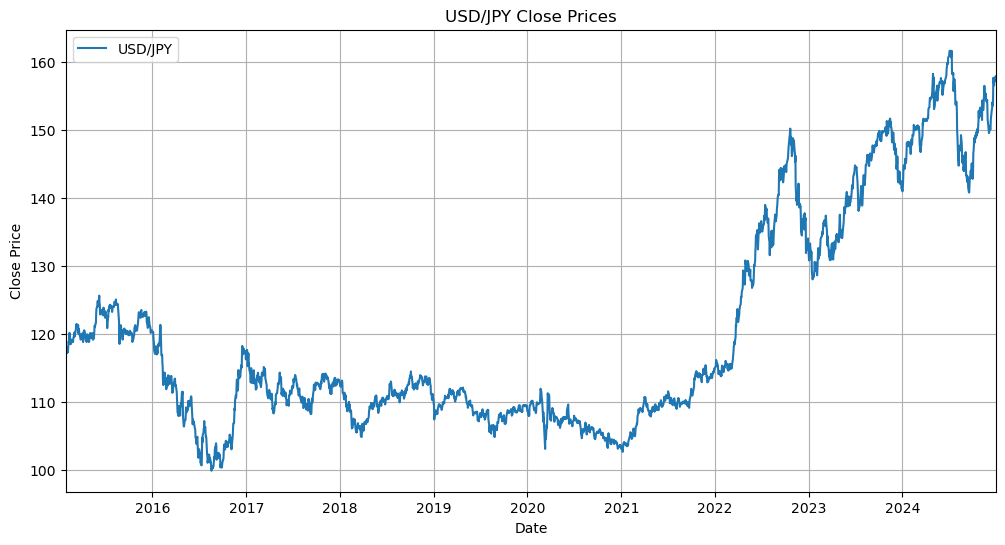

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(yen.Date, yen.Close, label='USD/JPY')
plt.title('USD/JPY Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(yen.Date), max(yen.Date))
plt.legend()
plt.grid(True)
plt.show()

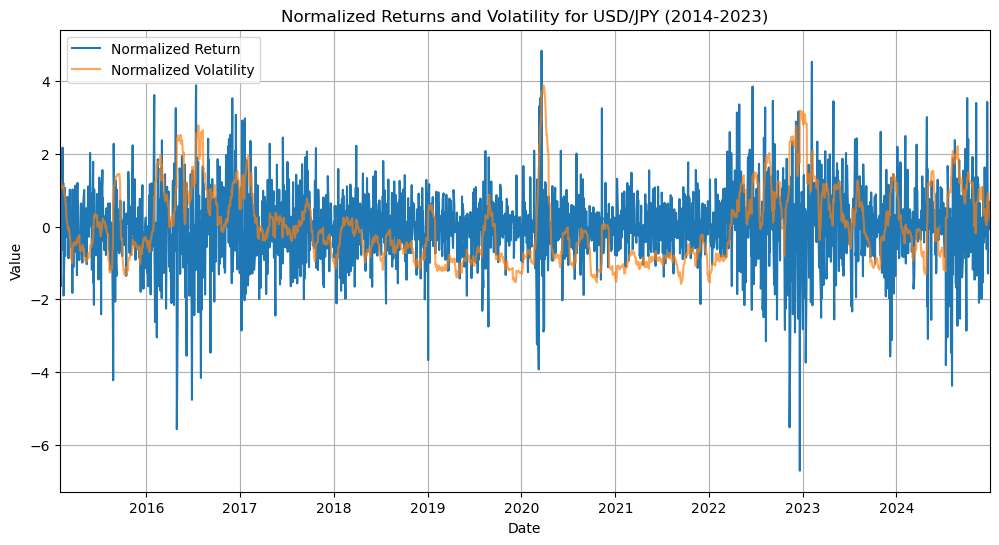

In [14]:
# Visualize the normalized returns and volatility
plt.figure(figsize=(12, 6))
plt.plot(yen.Date, yen['Return'], label='Normalized Return')
plt.plot(yen.Date, yen['Volatility'], label='Normalized Volatility', alpha=0.7)
plt.title('Normalized Returns and Volatility for USD/JPY (2014-2023)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xlim(min(yen.Date), max(yen.Date))
plt.legend()
plt.grid(True)
plt.show()

K-Means Clustering to identify market regimes.

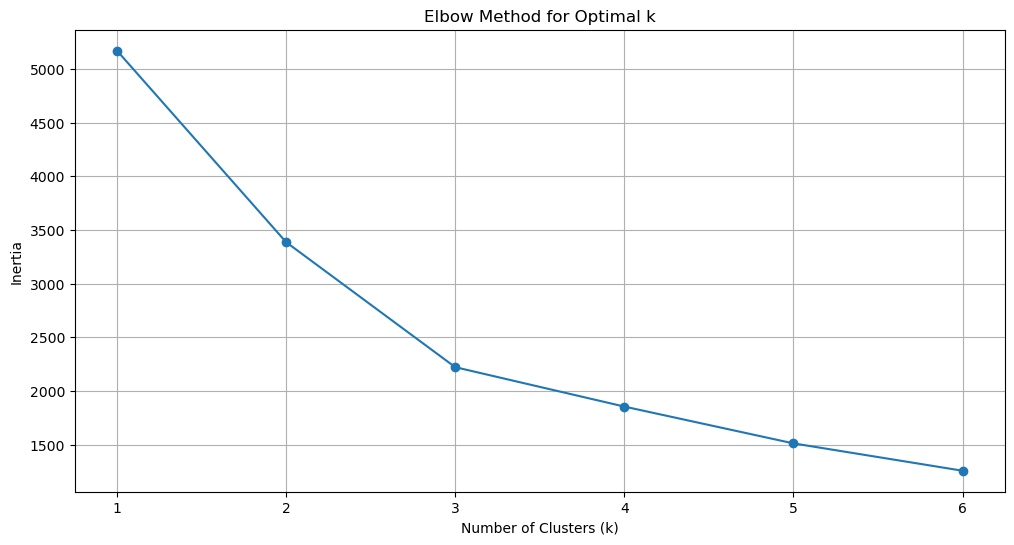

In [16]:
ks = range(1, 7)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(yen[['Return', 'Volatility']])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show()

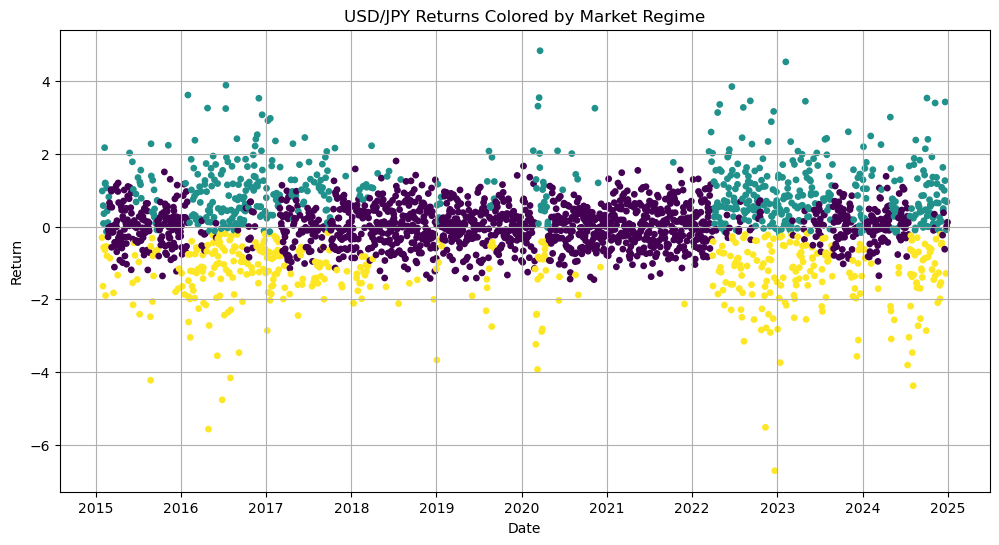

In [17]:
np.random.seed(120)

# Fit the K-Means model with the optimal number of clusters
kmeans_model = KMeans(n_clusters = 3)
yen['K Regime'] = kmeans_model.fit_predict(yen[['Return', 'Volatility']])

# One-hot encoding of the K Regime column
one_hot = pd.get_dummies(yen['K Regime'], prefix='Regime').astype(int)

# Add the one-hot encoded columns to the yen DataFrame
yen = pd.concat([yen, one_hot], axis=1)

# Plot the clustering results
plt.figure(figsize=(12, 6))
plt.scatter(yen.Date, yen.Return, c=yen['K Regime'], cmap='viridis', label='Market Regime', s=15)
plt.title('USD/JPY Returns Colored by Market Regime')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

Summary of Market Regimes:
            Return  Volatility
K Regime                      
0         0.010733   -0.644053
1         0.981679    0.983742
2        -1.328775    0.896519


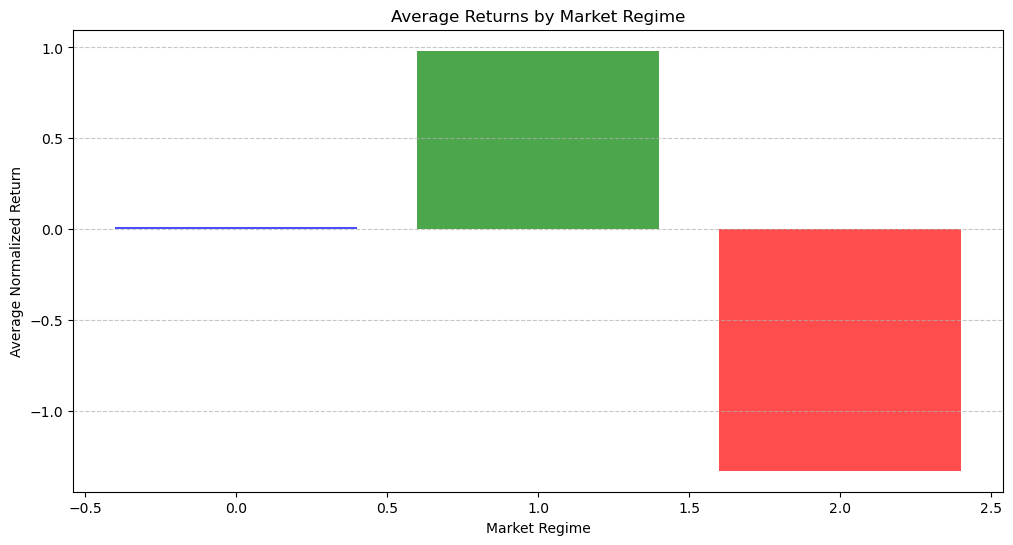

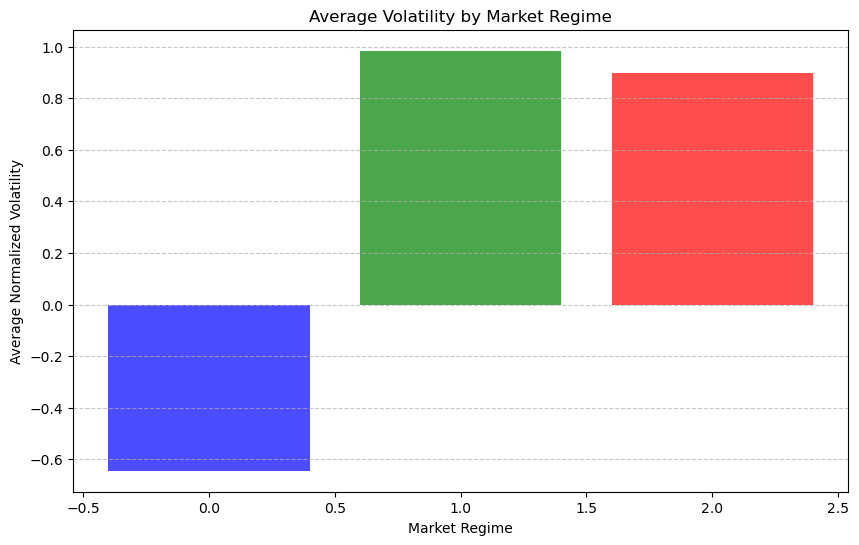

In [18]:
# Analyze the behavior of the market regimes
regime_summary = yen.groupby('K Regime').mean()[['Return', 'Volatility']]
print("Summary of Market Regimes:")
print(regime_summary)

# Plot the average return and volatility for each regime
plt.figure(figsize=(12, 6))
plt.bar(regime_summary.index, regime_summary['Return'], color=['blue', 'green', 'red'], alpha=0.7)
plt.xlabel('Market Regime')
plt.ylabel('Average Normalized Return')
plt.title('Average Returns by Market Regime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(regime_summary.index, regime_summary['Volatility'], color=['blue', 'green', 'red'], alpha=0.7)
plt.xlabel('Market Regime')
plt.ylabel('Average Normalized Volatility')
plt.title('Average Volatility by Market Regime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
yen

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Volatility,K Regime,Regime_0,Regime_1,Regime_2
20,2015-01-29,117.627998,118.154999,117.568001,117.592003,117.592003,0,-0.302332,1.139099,2,0,0,1
21,2015-01-30,118.248001,118.273003,117.403999,118.248001,118.248001,0,0.979178,1.195845,1,0,1,0
22,2015-02-02,117.184998,117.859001,117.167999,117.183998,117.183998,0,-1.639877,1.247232,2,0,0,1
23,2015-02-03,117.601997,117.720001,116.896004,117.574997,117.574997,0,0.576353,1.190879,1,0,1,0
24,2015-02-04,117.676003,117.983002,117.260002,117.646004,117.646004,0,0.085357,1.139120,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,2024-12-24,157.164993,157.376999,156.899994,157.164993,157.164993,0,0.702267,0.925928,1,0,1,0
2601,2024-12-25,157.106995,157.860992,146.201996,157.106995,157.106995,0,-0.089459,0.748168,1,0,1,0
2602,2024-12-26,157.132996,158.074997,157.080002,157.132996,157.132996,0,0.006582,0.443002,0,1,0,0
2603,2024-12-27,157.748001,157.914993,157.352005,157.748001,157.748001,0,0.680078,0.430588,1,0,1,0


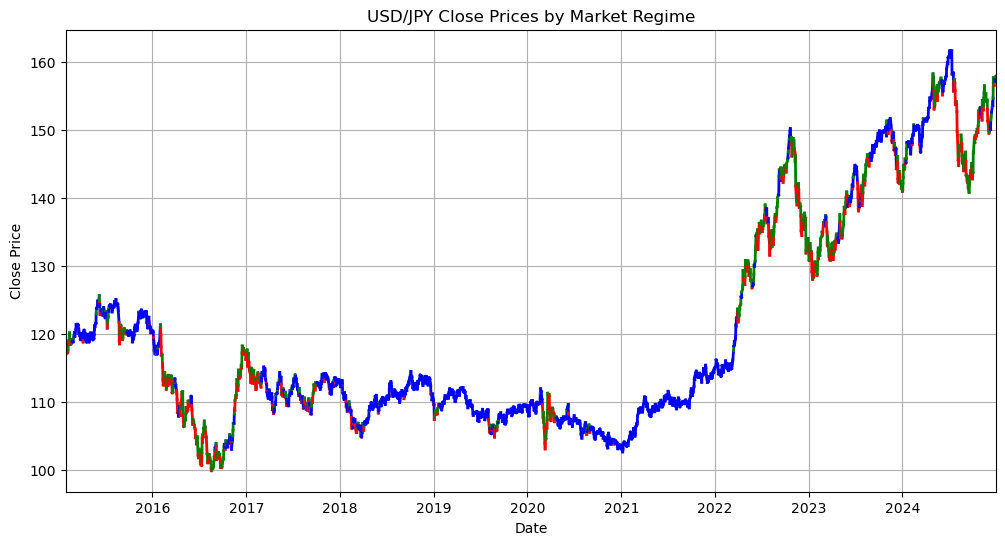

In [20]:
# Create a color map for the regimes
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))
for i in range(1, len(yen.Close.values)):
    if yen['K Regime'].values[i] != yen['K Regime'].values[i-1]: # When regime changes, start a new line segment
        plt.plot(yen.Date[i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i-1]], lw=2)
    else: # Keep plotting the same regime in the same color
        plt.plot(yen.Date[i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i]], lw=2)

plt.title('USD/JPY Close Prices by Market Regime')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(yen.Date), max(yen.Date))
plt.grid(True)
plt.show()

## Model

In [22]:
# Prepare data for LSTM model
test_size = yen[yen.Date.dt.year >= 2020].shape[0]
scaler = MinMaxScaler()

print(test_size)

1304


In [109]:
window_size = 60

# Define feature columns (close price and one-hot encoded regime columns)
feature_columns = ['Close'] + [col for col in yen.columns if col.startswith('Regime_')]

# Scale the close price
yen['Close_scaled'] = scaler.fit_transform(yen[['Close']])

# Split train and test data
train_data = yen[feature_columns][:-test_size]
test_data = yen[feature_columns][-test_size-window_size:]

# Convert DataFrame to NumPy array for LSTM input
train_data = train_data.values
test_data = test_data.values

train_data.size

5124

In [113]:
window_size = 60

# Scale the close price and regime features
train_data = yen[['Close', 'K Regime']][:-test_size]
test_data = yen[['Close', 'K Regime']][-test_size-window_size:]

train_data['Close_scaled'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close_scaled'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close_scaled'].values.reshape(-1, 1), train_data['K Regime'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close_scaled'].values.reshape(-1, 1), test_data['K Regime'].values.reshape(-1, 1)], axis=1)

train_data.size

2562

In [111]:
window_size = 60

# Scale the close price and regime features
train_data = yen[['Close']][:-test_size]
test_data = yen[['Close']][-test_size-window_size:]

train_data['Close_scaled'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close_scaled'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close_scaled'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close_scaled'].values.reshape(-1, 1)], axis=1)

train_data.size

1281

In [115]:
# Training Set
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, 0])

# Testing Set
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(train_data[0])))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(train_data[0])))

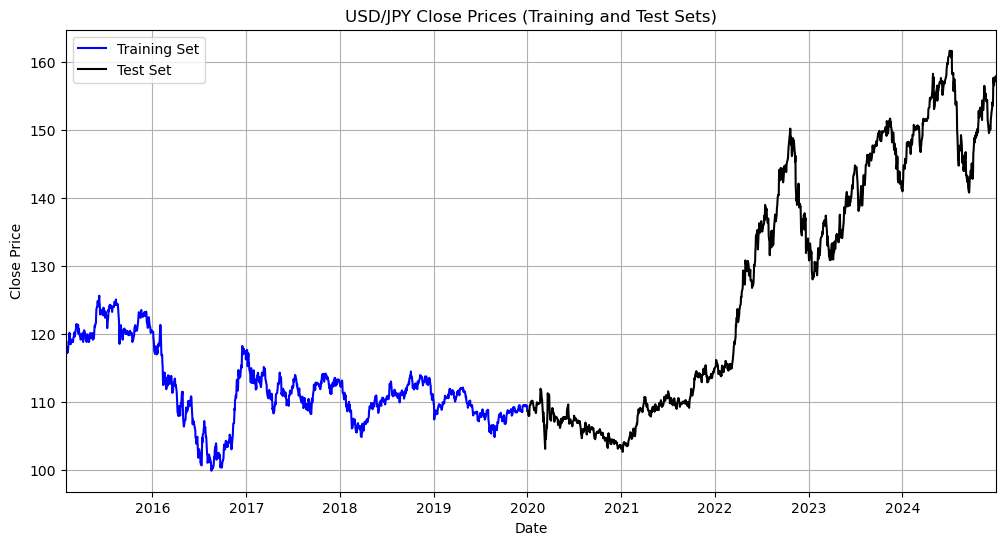

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(yen.Date[:-test_size], yen.Close[:-test_size], label="Training Set", color='blue')
plt.plot(yen.Date[-test_size:], yen.Close[-test_size:], label="Test Set", color='black')
plt.title('USD/JPY Close Prices (Training and Test Sets)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(min(yen.Date), max(yen.Date))
plt.legend()
plt.grid(True)
plt.show()

In [207]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(X_train.shape[2], 120, 3, batch_first = True, dropout = 0.2)
        self.fc1 = nn.Linear(120, 100)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 60)
        self.fc4 = nn.Linear(60, 40)
        self.fc5 = nn.Linear(40, 20)
        self.fc6 = nn.Linear(20, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x) # LSTM layers
        x = x[:, -1, :] # Normalize Output
        x = self.fc1(x)
        x = self.sigmoid(x) # Sigmoid activation
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        return x

In [209]:
torch.manual_seed(120)
np.random.seed(120)

num_epochs = 20
batch_size = 10
epoch_times = []

# Prepare data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    end_time = time.time()
    epoch_times.append(end_time - start_time)
    
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Time: {epoch_times[-1]:.2f} seconds')

Epoch 1, Training Loss: 0.047415, Validation Loss: 0.673585, Time: 4.69 seconds
Epoch 2, Training Loss: 0.034801, Validation Loss: 0.269197, Time: 4.53 seconds
Epoch 3, Training Loss: 0.010004, Validation Loss: 0.075437, Time: 4.66 seconds
Epoch 4, Training Loss: 0.004382, Validation Loss: 0.063975, Time: 4.53 seconds
Epoch 5, Training Loss: 0.003690, Validation Loss: 0.056786, Time: 4.50 seconds
Epoch 6, Training Loss: 0.003081, Validation Loss: 0.043101, Time: 4.54 seconds
Epoch 7, Training Loss: 0.002871, Validation Loss: 0.044908, Time: 4.58 seconds
Epoch 8, Training Loss: 0.002830, Validation Loss: 0.040570, Time: 4.46 seconds
Epoch 9, Training Loss: 0.002120, Validation Loss: 0.042081, Time: 4.49 seconds
Epoch 10, Training Loss: 0.002221, Validation Loss: 0.039606, Time: 4.51 seconds
Epoch 11, Training Loss: 0.002359, Validation Loss: 0.051859, Time: 4.47 seconds
Epoch 12, Training Loss: 0.002563, Validation Loss: 0.076366, Time: 4.47 seconds
Epoch 13, Training Loss: 0.001981, Va

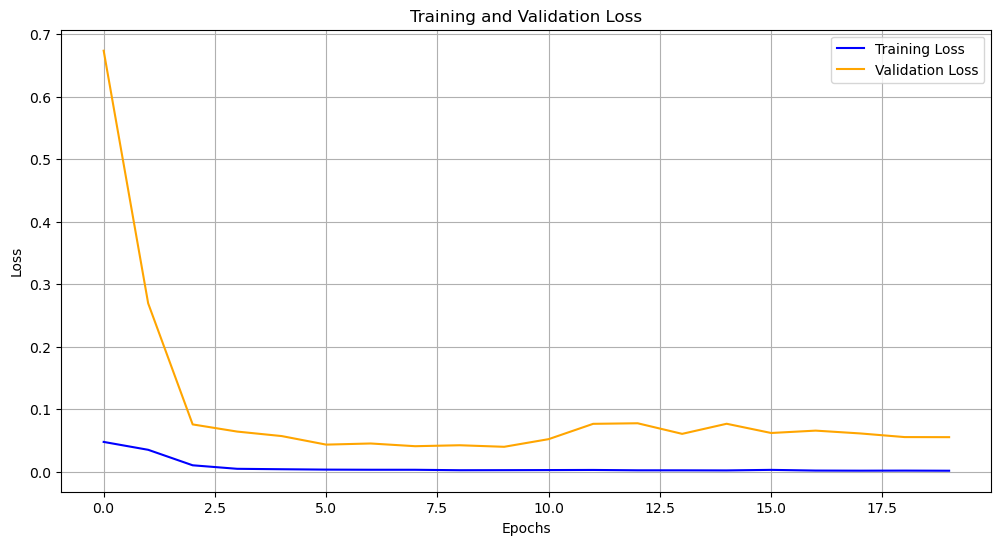

In [210]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [211]:
# Testing and Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy())

y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

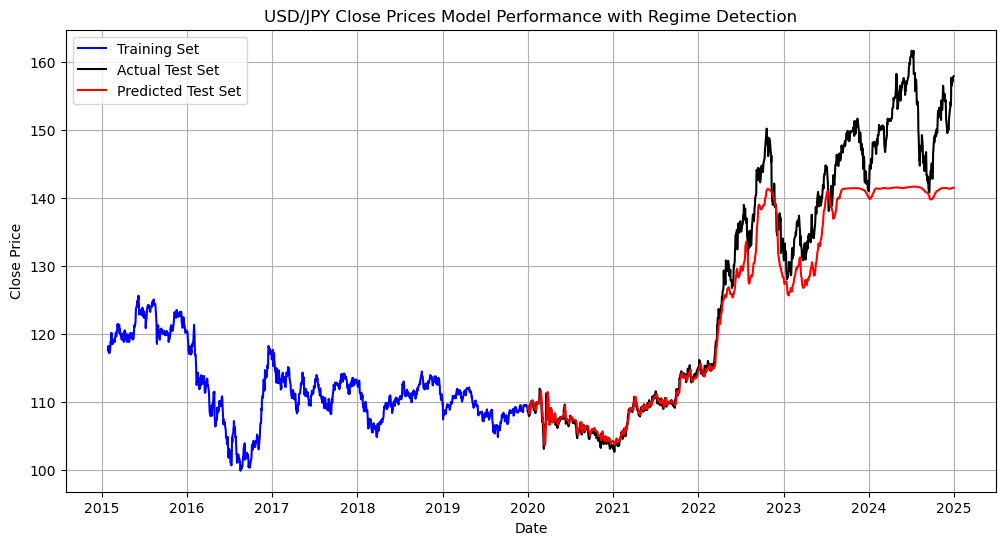

In [212]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(yen.Date[:-test_size], yen.Close[:-test_size], label="Training Set", color='blue')
plt.plot(yen.Date.iloc[-test_size:], y_test_true, label="Actual Test Set", color='black')
plt.plot(yen.Date.iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='red')
plt.title('USD/JPY Close Prices Model Performance with Regime Detection')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

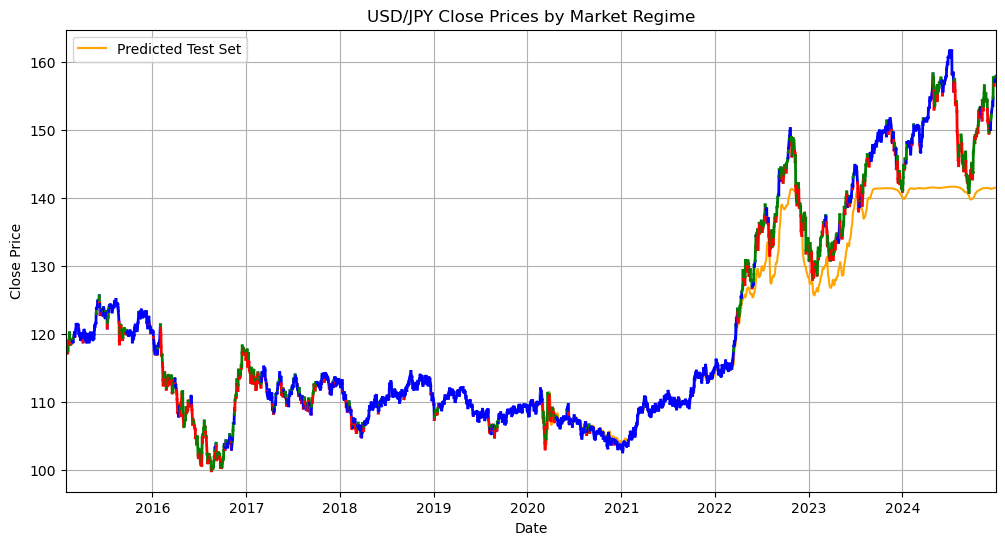

In [213]:
# Create a color map for the regimes
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))

plt.plot(yen.Date.iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='orange')

for i in range(1, len(yen.Close.values)):
    if yen['K Regime'].values[i] != yen['K Regime'].values[i-1]: # When regime changes, start a new line segment
        plt.plot(yen.Date[i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i-1]], lw=2)
    else: # Keep plotting the same regime in the same color
        plt.plot(yen.Date[i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i]], lw=2)

plt.title('USD/JPY Close Prices by Market Regime')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xlim(min(yen.Date), max(yen.Date))
plt.grid(True)
plt.show()

In [214]:
def test_model(model, X_test, y_test):
    model.eval()
    y_pred = model(torch.tensor(X_test).float().to(device))
    y_pred = y_pred.detach().cpu().numpy().flatten()
    
    test_loss = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    Accuracy = 1 - MAPE

    return y_pred, test_loss, MAPE, Accuracy

y_test_pred, test_loss, MAPE, Accuracy = test_model(model, X_test, y_test)

print(f"Test Loss (MAE): {test_loss:.6f}")
print(f"Test MAPE: {MAPE:.6f}")
print(f"Test Accuracy: {Accuracy:.6f}")

Test Loss (MAE): 0.158703
Test MAPE: 0.117331
Test Accuracy: 0.882669
